In [1]:
# Import library
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/workspaces/machine_learning_zoomcamp/bank-full.csv', sep=';')
df = df.drop(columns=['default', 'loan'])
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


### Question-1

In [3]:
# Dropping the unnamed column and encoding target variable 'y' to binary (yes: 1, no: 0)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Selecting the numerical variables and target variable 'y'
numerical_cols = ['age', 'balance', 'duration', 'campaign']
target = 'y'

# Splitting the data into train (60%), validation (20%), and test (20%) sets using train_test_split
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.4, random_state=1, stratify=df['y'])
df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=1, stratify=df_temp['y'])

from sklearn.metrics import roc_auc_score

def compute_auc_and_invert(df_train, numerical_cols, target):
    auc_results = {}
    
    for col in numerical_cols:
        auc = roc_auc_score(df_train[target], df_train[col])
        
        if auc < 0.5:
            # Invert the variable if AUC is less than 0.5
            df_train[col] = -df_train[col]
            auc = roc_auc_score(df_train[target], df_train[col])
        
        auc_results[col] = auc
    
    return auc_results

# Compute AUC for each numerical variable
auc_scores = compute_auc_and_invert(df_train, numerical_cols, target)
auc_scores

{'age': np.float64(0.5094149011664284),
 'balance': np.float64(0.5932258557239465),
 'duration': np.float64(0.8107269279532064),
 'campaign': np.float64(0.5703298121548543)}

### Question-2

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# One-hot encoding using DictVectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(df_train.drop(columns=[target]).to_dict(orient='records'))
X_validation = dv.transform(df_validation.drop(columns=[target]).to_dict(orient='records'))

# Logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, df_train[target])

# Predictions and AUC on validation dataset
y_validation_pred = model.predict_proba(X_validation)[:, 1]
auc_validation = roc_auc_score(df_validation[target], y_validation_pred)
auc_validation


np.float64(0.8995699338184877)

#### Question-3

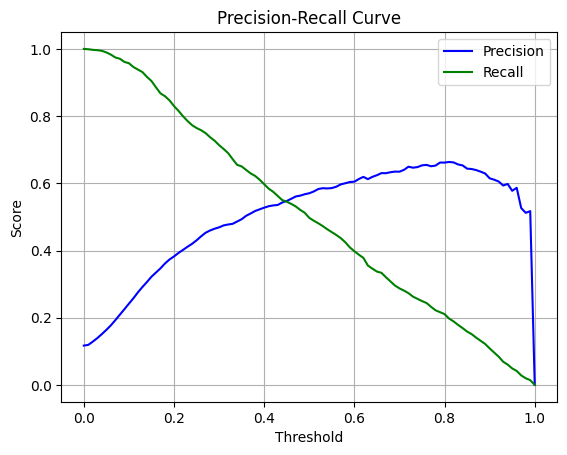

In [8]:
import matplotlib.pyplot as plt

y_validation_pred_proba = model.predict_proba(X_validation)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

# Iterate over each threshold
for threshold in thresholds:
    y_pred = (y_validation_pred_proba >= threshold).astype(int)
    
    tp = np.sum((y_pred == 1) & (df_validation[target] == 1))
    fp = np.sum((y_pred == 1) & (df_validation[target] == 0))
    fn = np.sum((y_pred == 0) & (df_validation[target] == 1))
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

precisions = np.array(precisions)
recalls = np.array(recalls)
threshold_intersection = thresholds[np.argmin(np.abs(precisions - recalls))]

#### Question-4

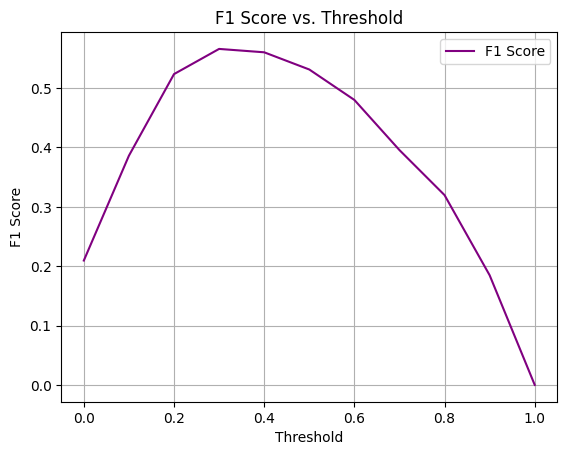

np.float64(0.30000000000000004)

In [10]:
thresholds = np.arange(0.0, 1.01, 0.1)
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    y_pred = (y_validation_pred_proba >= threshold).astype(int)
    
    tp = np.sum((y_pred == 1) & (df_validation[target] == 1))
    fp = np.sum((y_pred == 1) & (df_validation[target] == 0))
    fn = np.sum((y_pred == 0) & (df_validation[target] == 1))
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    
    # Compute F1 score
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    f1_scores.append(f1)

# Plot F1 score
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

f1_scores = np.array(f1_scores)
threshold_max_f1 = thresholds[np.argmax(f1_scores)]
max_f1_score = f1_scores[np.argmax(f1_scores)]
threshold_max_f1

#### Question-5

In [12]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

target = 'y'
df_full_train = df.drop(columns=[target])
y_full_train = df[target]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

# Iterate over each fold
for train_index, val_index in kf.split(df_full_train):
    X_train, X_val = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
    y_train, y_val = y_full_train.iloc[train_index], y_full_train.iloc[val_index]

    dv = DictVectorizer()
    X_train_dv = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val_dv = dv.transform(X_val.to_dict(orient='records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_train_dv, y_train)

    y_val_pred = model.predict_proba(X_val_dv)[:, 1]

    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)

auc_std = np.std(auc_scores)
auc_scores, auc_std


([np.float64(0.9069509630450453),
  np.float64(0.8989261029741773),
  np.float64(0.9055266745586685),
  np.float64(0.9124494732828068),
  np.float64(0.9067924338924525)],
 np.float64(0.004319922955648932))

#### Question-6

In [13]:
C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    auc_scores = []
    
    for train_index, val_index in kf.split(df_full_train):
        X_train, X_val = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
        y_train, y_val = y_full_train.iloc[train_index], y_full_train.iloc[val_index]

        dv = DictVectorizer()
        X_train_dv = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val_dv = dv.transform(X_val.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
        model.fit(X_train_dv, y_train)

        y_val_pred = model.predict_proba(X_val_dv)[:, 1]

        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)
    
    mean_auc = round(np.mean(auc_scores), 3)
    std_auc = round(np.std(auc_scores), 3)
    
    results[C] = (mean_auc, std_auc)

best_C = max(results, key=lambda x: results[x][0])
results, best_C

({1e-06: (np.float64(0.705), np.float64(0.011)),
  0.001: (np.float64(0.868), np.float64(0.006)),
  1: (np.float64(0.906), np.float64(0.004))},
 1)